# IEEEP370 Deembedding
## Table of Content
* [Single-ended](#single-ended)
 * [Simulation of 2xThru, DUT and Fixture-DUT-Fixture](#se-preparation)
 * [IEEEP370_SE_NZC_2xthru without impedance correction](#nzc)
 * [IEEEP370_SE_ZC_2xthru with impedance correction](#zc)
 * [Single Ended Comparison with AICC De-Embedding Utility](#aicc)
* [Mixed mode](#mixed-mode)
 * [Simulation of 2xThru, DUT and Fixture-DUT-Fixture](#mm-preparation)
 * [IEEEP370_MM_NZC_2xthru without impedance correction](#mmnzc)
 * [IEEEP370_MM_ZC_2xthru with impedance correction](#mmzc)
 * [Mixed Mode Comparison with AICC De-Embedding Utility](#mmaicc)


## Introduction

The [IEEE 370 standard](https://standards.ieee.org/ieee/370/6165/) provides good practices for ensuring the quality of measured data for high-frequency electrical interconnects at frequencies up to 50 GHz. It recommends methods and processes for ensuring the accuracy and consistency of measured data for signals with frequency content up to 50 GHz, in particular for removing test fixture and instrumentation effects.

In the examples below, and following the standard proposal on labeling, a 2-port DUT has one fixture attached to each of its ports. The fixture attached to the single-ended DUT port 1 is labeled as FIX-1. The fixture attached to the single-ended DUT port 2 is labeled as FIX-2. The cascade of the DUT and fixtures on both ends is named the composite structure or the FIX-DUT-FIX structure.

<img src="fix-dut-fix.svg" width="400"/>

The combination of the two fixtures, such as FIX-1 connected to FIX-2, is referred to as a FIX-FIX structure or a *2x-Thru*.

<img src="fix-fix.svg" width="270"/>

The purpose of this notebook is to illustrate the `scikit-rf` implementation of the deembedding methods proposed within the  IEEE P370 standard to remove the test fixture effects.

First, let's make the necessary Python import statements:

In [14]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import  c, pi
from skrf.calibration import (IEEEP370_SE_NZC_2xThru, IEEEP370_MM_NZC_2xThru,
                              IEEEP370_SE_ZC_2xThru, IEEEP370_MM_ZC_2xThru,
                              IEEEP370)
from skrf.media import DefinedGammaZ0, MLine
rf.stylely()

## Single-ended <a class="anchor" id="single-ended"></a>
The algorithms can be used with 2-port single-ended networks.

### Simulation of 2xThru, DUT and Fixture-DUT-Fixture <a class="anchor" id="se-preparation"></a>
We use `scikit-rf` `MLine` media to simulate microstrip line artifacts. This is a convenient way to generate synthetic S-parameter networks without leaving Python to operate another software.

* `dut` is a a Beatty structure with a 3xWidth microstrip section connected left and right by two uniform 1xWidth microstrip lines.
* `fdf` is FIX-DUT-FIX, prolonging the DUT left and right with a microstrip line and a planar-to-coaxial connector.
* `s2xthru` is FIX-FIX and is the cascade of the two prolonging lines and connectors without the DUT. For example purpose, the width of the lines is altered by 8% to show the effect of impedance mismatch on the deembedding process.

The target is to get the left and right fixtures models and retrieve the DUT by deembedding them from FIX-DUT-FIX.

The microstrip lines are inspired by [this example](./Time domain reflectometry, measurement vs simulation.ipynb).

In [15]:
directory = 'ieeep370deembedding/'
freq = rf.Frequency(10e-3, 10, 1000, 'GHz')
W   = 3.00e-3
H   = 1.55e-3
T   = 50e-6
ep_r = 4.459
tanD = 0.0183
f_epr_tand = 1e9

# microstrip segments
MSL1 = MLine(frequency=freq, z0_port=50, w=W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# capacitive 3 x width Beatty structure
MSL2 = MLine(frequency=freq, z0_port=50, w=3*W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# microstrip segment with a 10% variation of width
MSL3 = MLine(frequency=freq, z0_port=50, w=0.92*W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tanD, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')

# connector SMA edge PCB mount soldered
CONN = DefinedGammaZ0(frequency=freq, gamma = 1j* 2 * pi * freq.f / c, z0_port = 50)
z_conn = 53.2    # ohm, connector impedance
d_conn = 50      # ps,   connector discontinuity delay
connector = CONN.line(50, 'ps', z0 = z_conn)

# building DUT
dut =    MSL1.line(20e-3, 'm') \
      ** MSL2.line(20e-3, 'm') \
      ** MSL1.line(20e-3, 'm')
dut.name = 'DUT'

# building FIXTURE-DUT-FIXTURE
thru1 = MSL1.line(25e-3, 'm')
thru3 = MSL3.line(25e-3, 'm')
fdf     = connector ** thru1 ** dut ** thru1 ** connector
fdf.name = 'FIX-DUT-FIX'

# building FIXTURE-FIXTURE with a 8% width variation from FIXTURE-DUT-FIXTURE(2xthru)
s2xthru = connector ** thru3 ** thru3 ** connector
s2xthru.name = '2x-Thru'

# extrapolate to DC for time step
dut_dc = IEEEP370.extrapolate_to_dc(dut)
fdf_dc = IEEEP370.extrapolate_to_dc(fdf)
s2xthru_dc = IEEEP370.extrapolate_to_dc(s2xthru)
# set True to write .s2p files
if False:
    s2xthru.write_touchstone(directory + 'se_2xthru_nonoise.s2p')
    fdf.write_touchstone(directory + 'se_fdf_nonoise.s2p')

C:\Users\huser\kDrive2\prj\048-scikit-rf\scikit-rf\skrf\media\mline.py:276: RuntimeWarning: Conductor loss calculation invalid for lineheight t (5e-05)  < 3 * skin depth (2.0824376719439517e-05)
  self.alpha_conductor, self.alpha_dielectric = self.analyse_loss(


In the figure below, the time shift of DUT caused by the fixtures is visible on FIX-DUT-FIX trace. The 2x-Thru trace shows the awaited impedance mismatch with the FIX-DUT-FIX. The connectors add an impedance bump at the ends of 2x-Thru and FIX-DUT-FIX impedance step response. The reference DUT is the Beatty structure alone, without fixtures.

The `_dc` networks were extrapolated to DC for the time-domain step plot.

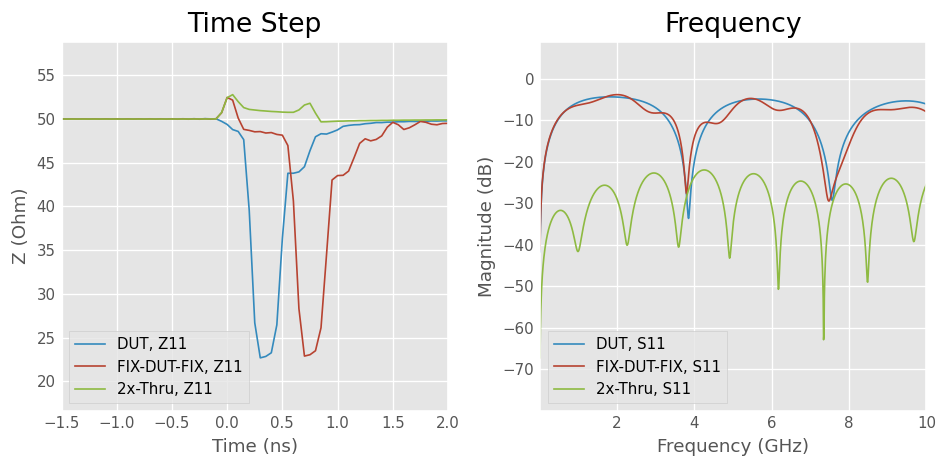

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_title('Time Step')
dut_dc.plot_z_time_step(0, 0, ax = axs[0])
fdf_dc.plot_z_time_step(0, 0, ax = axs[0])
s2xthru_dc.plot_z_time_step(0, 0, ax = axs[0])
axs[0].set_xlim((-1.5, 2))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
dut.plot_s_db(0, 0, ax = axs[1])
fdf.plot_s_db(0, 0, ax = axs[1])
s2xthru.plot_s_db(0, 0, ax = axs[1])
axs[1].legend(loc = 'lower left')
fig.tight_layout()

First, check the quality metrics of the data to ensure they do not violate passivity, reciprocity, or causality. Initial quality checking in the frequency domain results in percentage scores and is informative only. The results are evaluated as good, acceptable, inconclusive or poor. Inconclusive or poor results may indicate the need to recalibrate the VNA and perform the measurements again.

Application-based quality checking in the time domain compares the original data to reconstructed S-parameters with enforced passivity, reciprocity, and causality. The quality estimations are in physical units such as voltage and time. `scikit-rf` does not implement application-based checking.

In [34]:
print('Frequency domain initial quality checking')

qm_2xthru = IEEEP370.check_fd_se_quality(s2xthru)
print(f'{s2xthru.name}:')
for k, v in qm_2xthru.items():
    print(f'{k}: {v}')

qm_fdf = IEEEP370.check_fd_se_quality(fdf)
print(f'{fdf.name}:')
for k, v in qm_fdf.items():
    print(f'{k}: {v}')

Frequency domain initial quality checking
2x-Thru:
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 100.0, 'evaluation': 'Good'}
FIX-DUT-FIX:
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 100.0, 'evaluation': 'Good'}


Before exercising the deembedding algorithms, the compliance of input data with IEEE 370 fixture electrical requirements (FER) shall be verified.

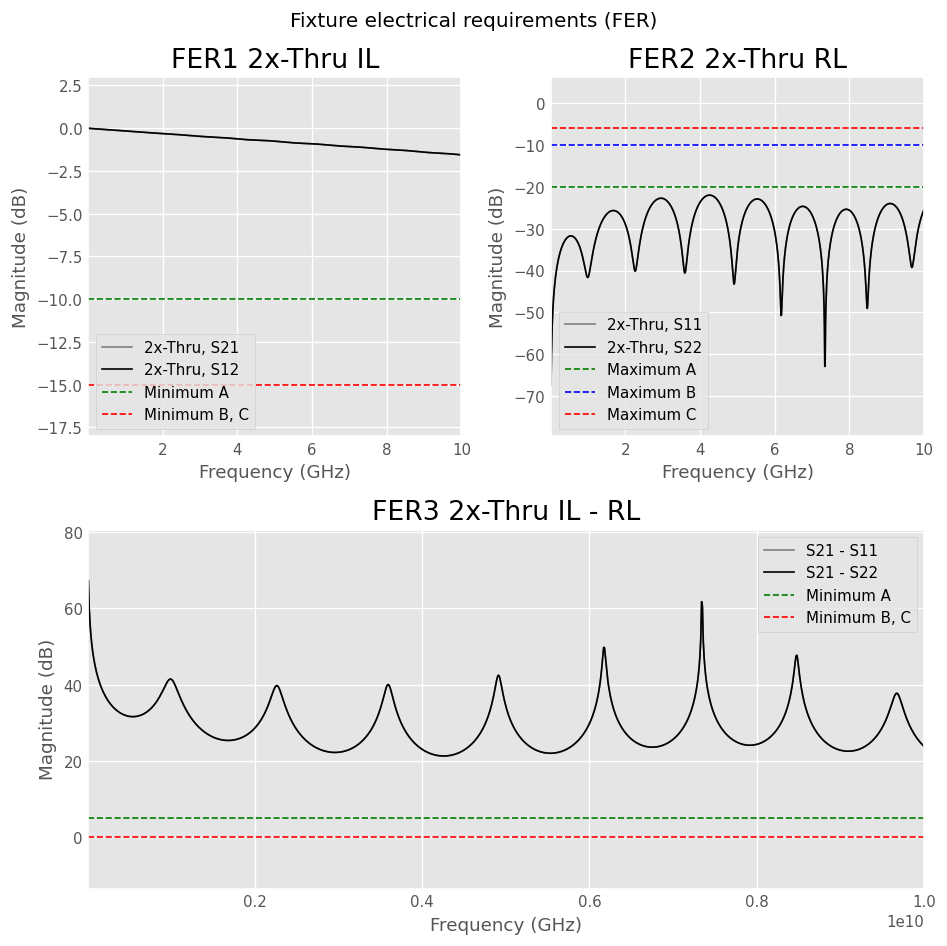

In [18]:
fig = IEEEP370.plot_check_se_fer_s(s2xthru)

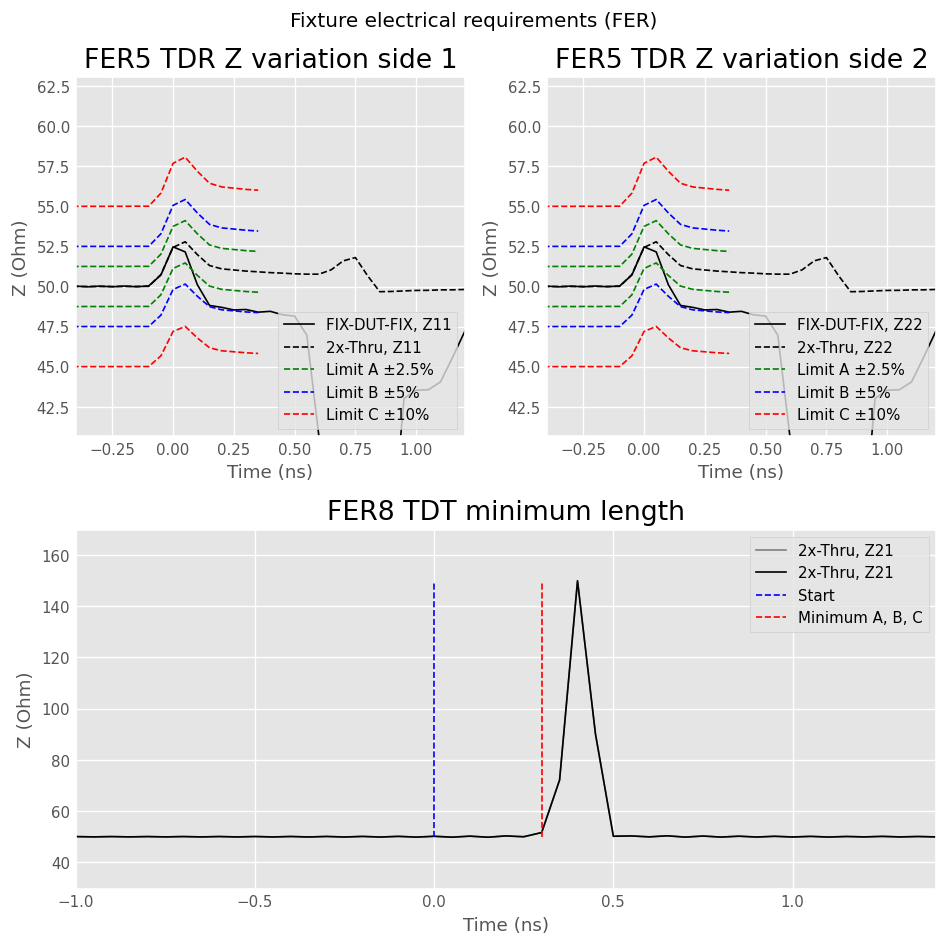

In [19]:
fig = IEEEP370.plot_check_se_fer_z(s2xthru, fdf)

The performance of the 2x-Thru is deemed class B compliant for frequencies below 10 GHz. This is due to the artificial impedance mismatch between 2x-Thru and FIX-DUT-FIX that fails the FER5 A limit.

### IEEEP370_SE_NZC_2xthru without impedance correction <a class="anchor" id="nzc"></a>
This method takes the 2x-Thru as input. It is a simple and efficient bisection algorithm that cannot correct for the difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX. This unwanted difference should be minimized. It can appear because of materials inhomogeneities, manufacturing processes, or if the artifacts are not built on the same board.

The S-parameters bisection is done by time gating S11 and S22, taking the proper square root of the S21 corrected by return loss, and remixing the parameters according to the fixture signal flow graph. This method gives crude results but is robust.

IEEE 370 recommends the following consistency tests:

* Self de-embedding of 2x-Thru with absolute magnitude of residual insertion loss < ±0.1 dB and residual phase < ±1°
* Compare the TDR of the fixture model to the FIX-DUT-FIX
 
  

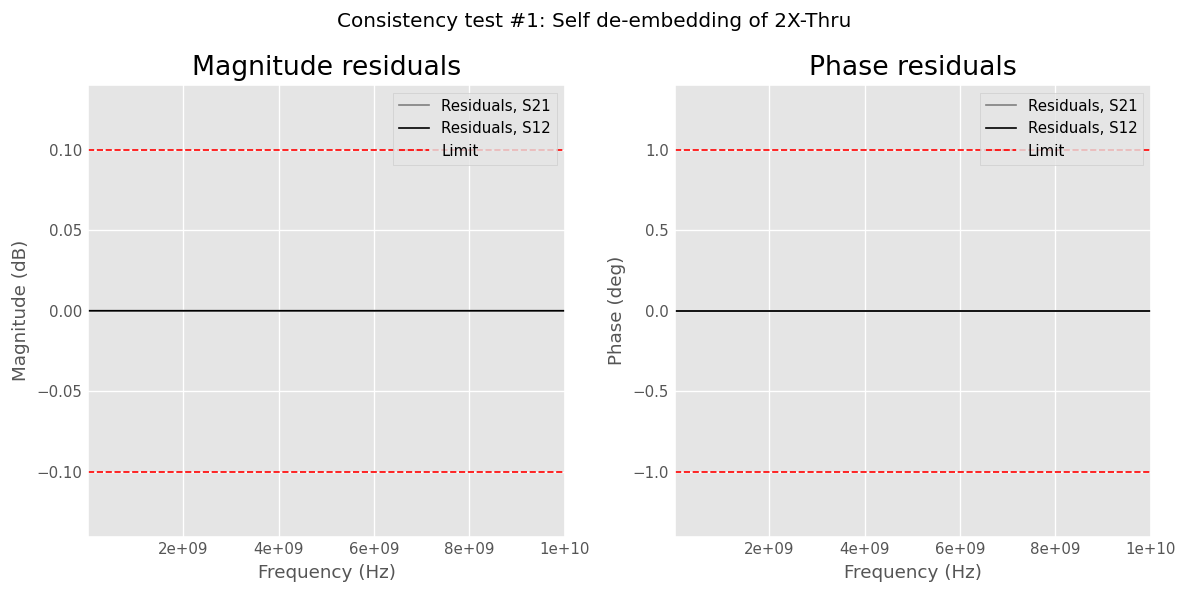

In [20]:
dm_nzc = IEEEP370_SE_NZC_2xThru(dummy_2xthru = s2xthru, name = '2xthru')
nzc_fix1 = dm_nzc.s_side1
nzc_fix1.name = 'nzc_FIX-1'
nzc_fix2 = dm_nzc.s_side2
nzc_fix2.name = 'nzc_FIX-2'
nzc_d_dut = dm_nzc.deembed(fdf)
nzc_d_dut.name = 'nzc_DUT'
nzc_fix1_dc = IEEEP370.extrapolate_to_dc(nzc_fix1)
nzc_d_dut_dc = IEEEP370.extrapolate_to_dc(nzc_d_dut)

fig, ax = dm_nzc.plot_check_residuals()

The agreement between fixtures models and 2xthru is excellent, as shown by the magnitude and phase of residuals being much smaller than IEEEP370 ±0.1 dB and ±1° limits.

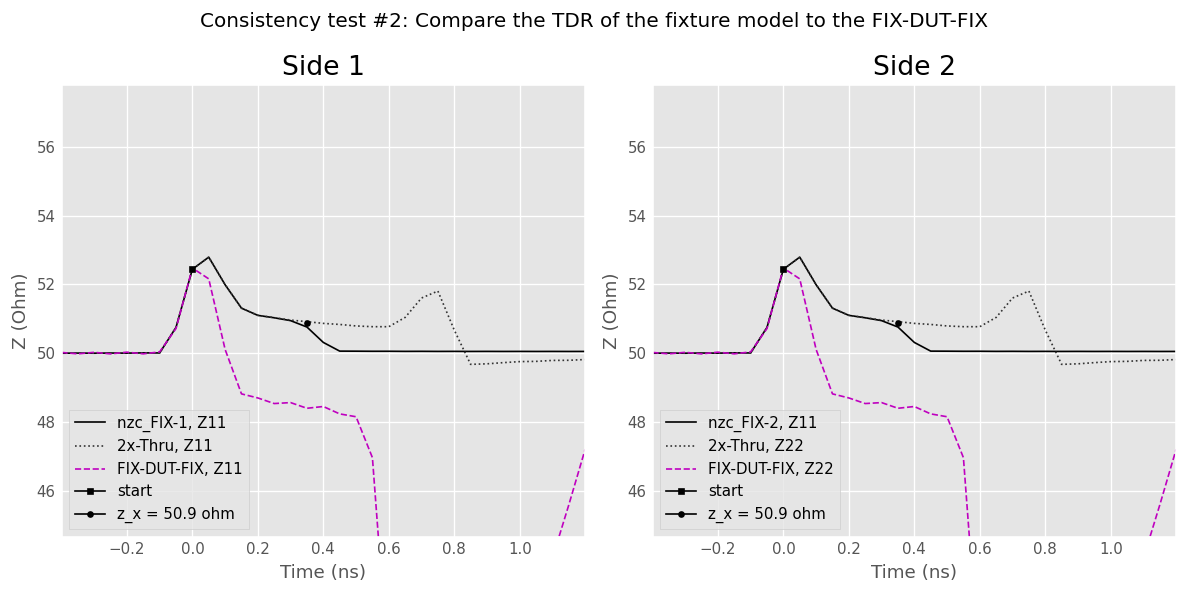

In [21]:
fig, ax = dm_nzc.plot_check_impedance(fdf)

Both fixtures show a close agreement with 2x-Thru from the start to the middle. However, the 5% artificial impedance mismatch added between 2x-Thru and FIX-DUT-FIX will deteriorate the DUT deembedding performance.

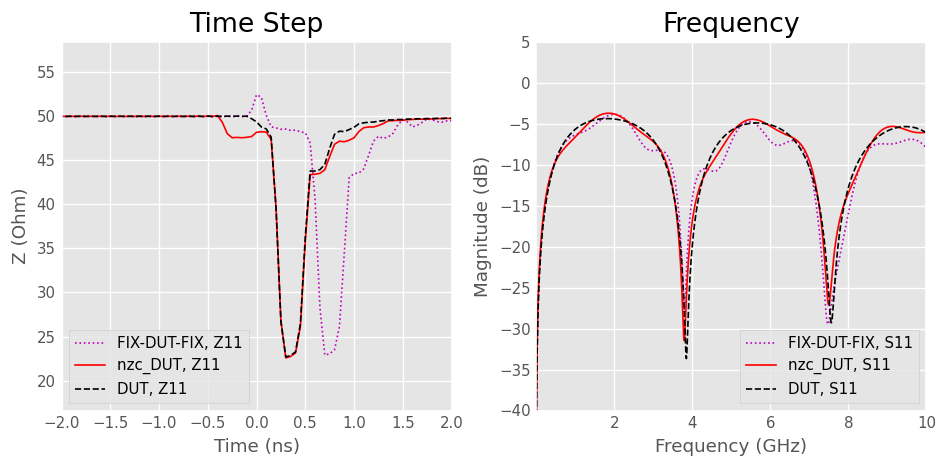

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Time Step')
fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
nzc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-2, 2))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
nzc_d_dut.plot_s_db(0, 0, ax = axs[1], color = 'r')
dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

The NZC deembedding algorithm has removed the delay of the fixtures. As expected, the impedance mismatch between 2x-Thru and FIX-DUT-FIX deteriorates the de-embedding by leaving an impedance bounce before time zero in the time domain. It is also visible as a ripple in the frequency domain.

### IEEEP370_SE_ZC_2xThru with impedance correction <a class="anchor" id="zc"></a>
This method takes 2x-Thru and the FIX-DUT-FIX as inputs. The algorithm computes the length of the fixtures by halving the delay of 2x-Thru in time domain transmission. The propagation constant `gamma` is also determined from the 2xThru. It then peels the FIX-DUT-FIX time domain impedance profile iteratively in cycles of determining start impedance and deembedding a single time sample long transmission line.

Because the 2x-Thru is used only for length and propagation constant determination, the effect of an impedance mismatch with the FIX-DUT-FIX is reduced. If another FIX-DUT-FIX has to be de-embedded with the same fixtures, an impedance mismatch between the two FIX-DUT-FIX would have an adverse effect on deembedding performance.

This method is more advanced than `IEEEP370_SE_NZC_2xThru` 2x-Thru S-parameters bisection. It has more options and often gives better results at the expense of more processing power.

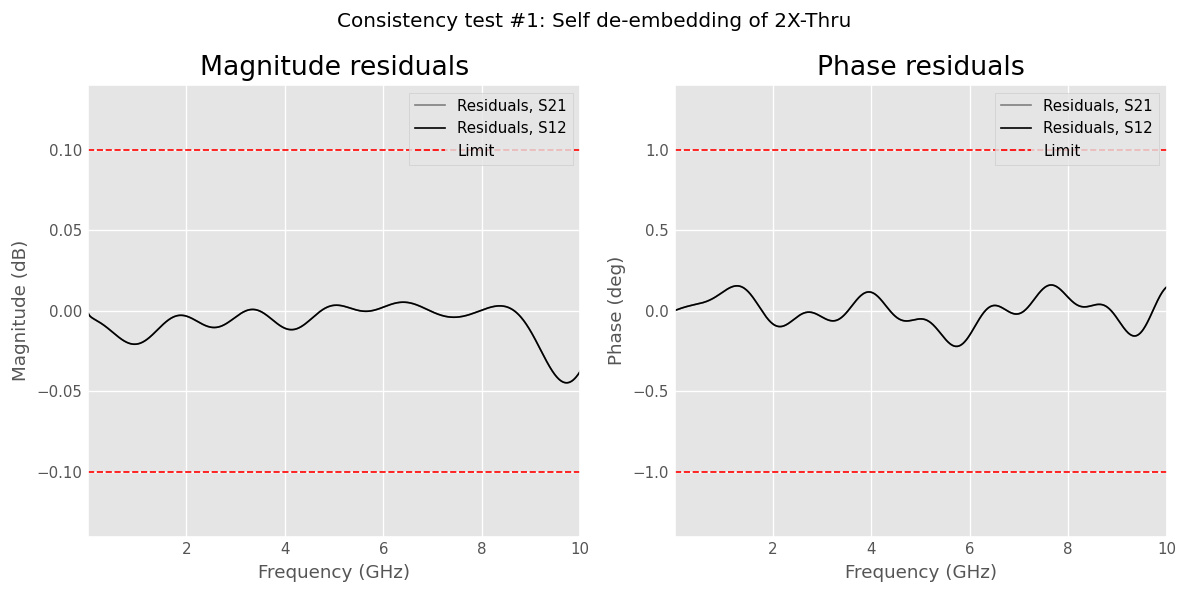

In [23]:
dm_zc  = IEEEP370_SE_ZC_2xThru(dummy_2xthru = s2xthru, dummy_fix_dut_fix = fdf,
                         bandwidth_limit = 10e9, pullback1 = 0, pullback2 = 0,
                         leadin = 0, NRP_enable = False,
                         name = 'zc2xthru')
zc_d_dut = dm_zc.deembed(fdf)
zc_d_dut.name = 'zc_DUT'
zc_fix1 = dm_zc.s_side1
zc_fix1.name = 'zc_FIX-1'
zc_fix2 = dm_zc.s_side2
zc_fix2.name = 'zc_FIX-2'
zc_fix1_dc = IEEEP370.extrapolate_to_dc(zc_fix1)
zc_d_dut_dc = IEEEP370.extrapolate_to_dc(zc_d_dut)

fig, ax = dm_zc.plot_check_residuals()

The agreement between fixtures models and 2xthru is good, as shown by the magnitude and phase of residuals being smaller than IEEE 370 ±0.1 dB and ±1° limits.

The residuals are higher than than with the NZC algorithm. This is the awaited result because the fixtures are modeled on the FIX-DUT-FIX impedance profile that has an artificially added impedance mismatch with the 2x-Thru.

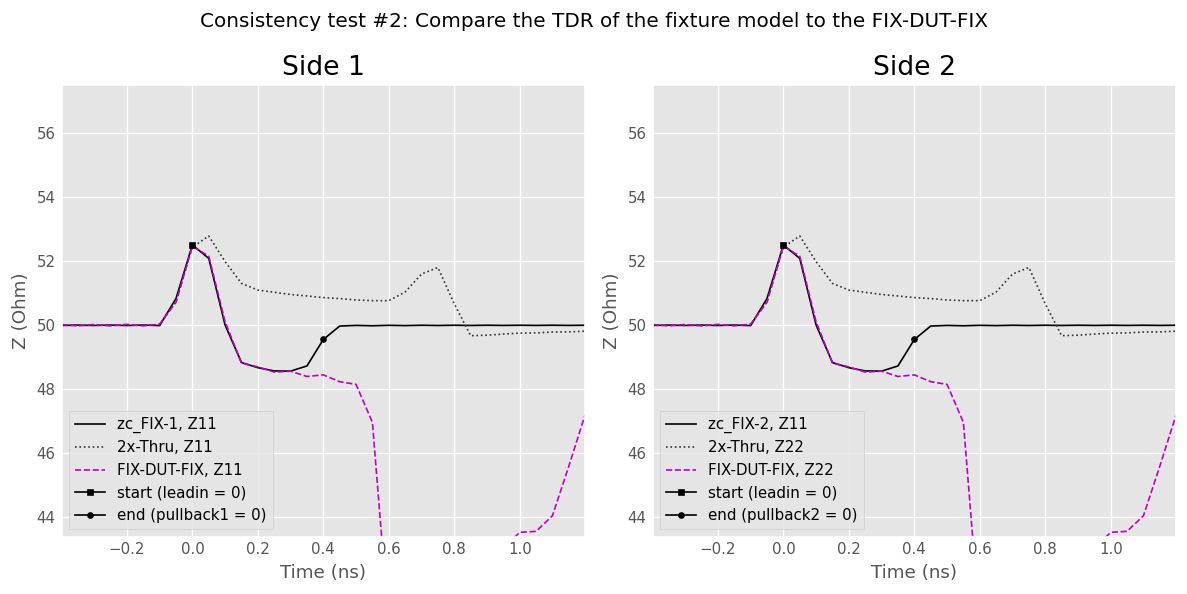

In [24]:
fig, ax = dm_zc.plot_check_impedance()

Both fixtures show a close agreement with FIX-DUT-FIX from the start to the middle. The 2x-Thru was used for fixture length and propagation constant gamma determination only.

The `leadin` option is useful if there is a need to capture several non-reference impedance samples before the time zero. The `pullback1` and `pullback2` options can shorten the fixtures by an integer number of time samples.

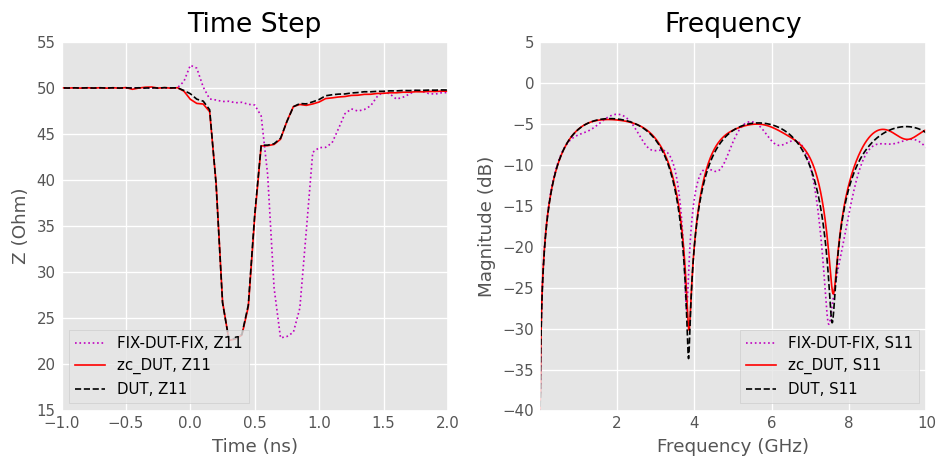

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Time Step')
fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
zc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-1, 2))
axs[0].set_ylim((15, 55))
axs[0].legend(loc = 'lower left')

axs[1].set_title('Frequency')
fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
zc_d_dut.plot_s_db(0, 0, ax = axs[1], color = 'r')
dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

As expected, the ZC deembedding algorithm shows a better agreement with the reference DUT than NZC, both in the time and frequency domains. This is because it is not impacted by the impedance mismatch between 2xThru and FIX-DUT-FIX of this example. This impedance difference should be minimized as much as possible in practical designs.

### Single Ended Comparison with AICC De-Embedding Utility <a class="anchor" id="aicc"></a>
A set of reference Matlab or Octave codes that implement the IEEEP370 NZC and ZC deembedding algorithms are available with an open-source BSD-3-Clause license [on the IEEE repository](https://opensource.ieee.org/elec-char/ieee-370/-/tree/master/TG1)

However, not everyone has access to Matlab and RF Toolbox. Maybe, this is one of the reasons why you are reading this text,  looking forward to using `scikit-rf` and Python.

A free compiled binary of Matlab routine with a GUI is available [on Amphenol website](https://www.amphenol-cs.com/software) with the name "ACS De-embedding Utility".
<img src="ieeep370deembedding/AICC_Deembedding.png">

Let's compare the output of this tool on `scikit-rf` port of deembedding algorithms as a consistency check.

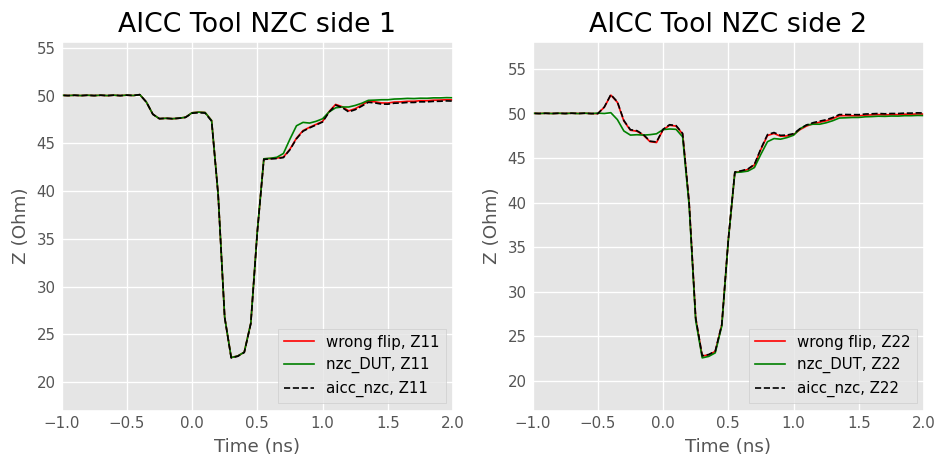

In [26]:
# read AICC generated files
nzc_ref = rf.Network(directory + 'deembedded_SE_NZC_se_fdf.s2p')
nzc_ref.name = 'aicc_nzc'
zc_ref = rf.Network(directory + 'deembedded_SE_ZC_se_fdf.s2p')
zc_ref.name = 'aicc_zc'
nzc_ref_dc = IEEEP370.extrapolate_to_dc(nzc_ref)
zc_ref_dc = IEEEP370.extrapolate_to_dc(zc_ref)

# make purposely wrong NZC side 2 flip for comparison with AICC Tool
nzc_wrong_d_dut = dm_nzc.s_side1.inv ** fdf ** dm_nzc.s_side2.inv
nzc_wrong_d_dut.name = 'wrong flip'
nzc_wrong_d_dut_dc = IEEEP370.extrapolate_to_dc(nzc_wrong_d_dut)

# compute absolute differences
# division of complex reflexion coeff is like substraction in dB and deg
delta_nzc = nzc_ref / nzc_wrong_d_dut
delta_zc = zc_ref / zc_d_dut

# plot them all
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('AICC Tool NZC side 1')
nzc_wrong_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
nzc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'g')
nzc_ref_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].legend(loc = 'lower right')
axs[0].set_xlim((-1, 2))

axs[1].set_title('AICC Tool NZC side 2')
nzc_wrong_d_dut_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'r')
nzc_d_dut_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'g')
nzc_ref_dc.plot_z_time_step(1, 1, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].legend(loc = 'lower right')
axs[1].set_xlim((-1, 2))

plt.tight_layout()

When comparing `scikit-rf` and `AICC` results, NZC algorithm exhibits a small discrepancy after the DUT section (green curve). This is because `AICC` FIX-2 has a wrong flip, which is demonstrated by the results of side 1 and side 2 being different for a symmetrical FIX-DUT-FIX (dashed black curve). If this error is propagated to `scikit-rf` for comparison's sake, the agreement is a perfect fit (red curve). The version of `AICC` used is 1.0.0.

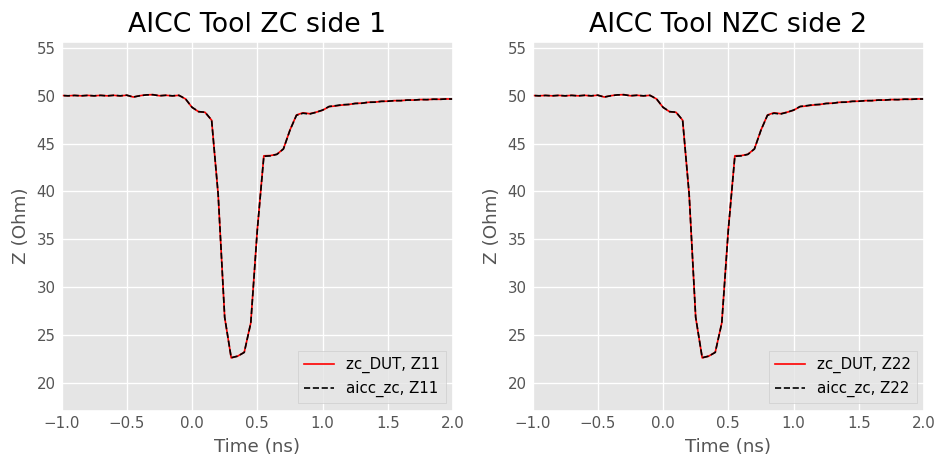

In [27]:
# plot them all
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('AICC Tool NZC side 1')

axs[0].set_title('AICC Tool ZC side 1')
zc_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
zc_ref_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].legend(loc = 'lower right')
axs[0].set_xlim((-1, 2))

axs[1].set_title('AICC Tool NZC side 2')
zc_d_dut_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'r')
zc_ref_dc.plot_z_time_step(1, 1, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].legend(loc = 'lower right')
axs[1].set_xlim((-1, 2))

plt.tight_layout()

When comparing `scikit-rf` and `AICC` results, ZC is visually a perfect fit in the time domain for both sides.

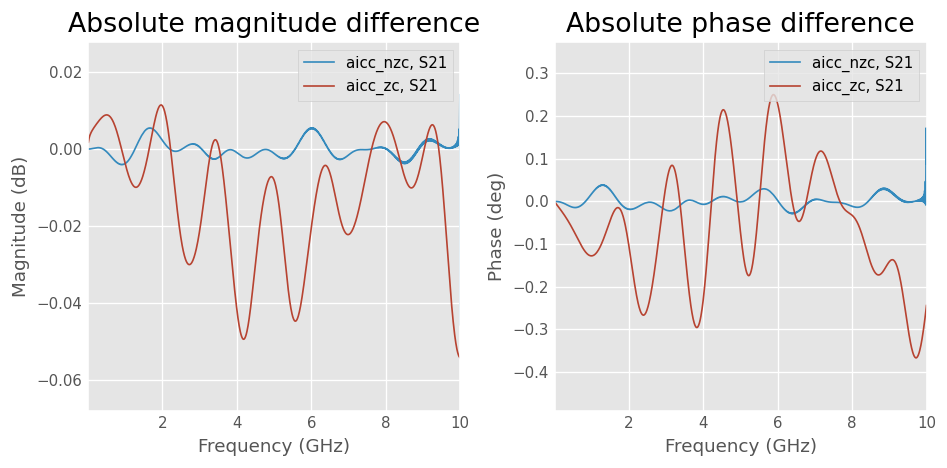

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Absolute magnitude difference')
delta_nzc.plot_s_db(1,0, ax = axs[0])
delta_zc.plot_s_db(1,0, ax = axs[0])
axs[0].legend(loc = 'upper right')

axs[1].set_title('Absolute phase difference')
delta_nzc.plot_s_deg(1,0, ax = axs[1])
delta_zc.plot_s_deg(1,0, ax = axs[1])
axs[1].legend(loc = 'upper right')

plt.tight_layout()

Both NZC (with flip error) and ZC absolute differences of magnitude and phase are within ±0.06 dB and ±0.4° up to 10 GHz, this is excellent.

In conclusion, for the single-ended case studied, `scikit-rf` gives consistent results with `AICC De-embedding Utility` implementation of IEEE 370 deembedding routines. It also solves the NZC FIX-2 flip error in `AICC De-embedding Utility` version 1.0.0.

## Mixed mode <a class="anchor" id="mixed-mode"></a>
ZC and NZC deembedding algorithms are compatible with differential 4-port networks.
Single-ended to generalized mixed-modes transformation is used to separate differential and common modes subnetworks and model the fixture individually. The differential and common modes fixtures are then merged and transformed into a 4-port single-ended again. This approach assumes differential to common mode transformation is insignificant.

### Simulation of 2xThru, DUT and Fixture-DUT-Fixture <a class="anchor" id="mm-preparation"></a>
We use [Qucs](http://qucs.sourceforge.net/) to simulate coupled microstrip line artifacts. This is a free simulator that can generate S-parameters of equation-based RF devices, among other things.

* `diff_dut` is a a Beatty structure with a 3xWidth coupled microstrip section connected left and right by two uniform 1xWidth coupled microstrip lines.
* `diff_fdf` is FIX-DUT-FIX, prolonging the DUT left and right with a coupled microstrip line and a planar-to-coaxial connector.
* `diff_2xthru` is FIX-FIX and is the cascade of the two prolonging lines and connectors without the DUT. For example purpose, the width of the lines is altered to show the effect of impedance mismatch on the deembedding process.

The target is to get the left and right fixtures models and retrieve the DUT by deembedding them from FIX-DUT-FIX.

The files and `qucs` sources are located in the directory `ieeep370deembedding` next to this notebook.

<img src="ieeep370deembedding/diff_fdf.png"> 

In the figure below, the time shift of DUT caused by the fixtures is visible on FIX-DUT-FIX trace. The 2x-Thru trace shows the awaited impedance mismatch with the FIX-DUT-FIX. The connectors add an impedance bump at the ends of 2x-Thru and FIX-DUT-FIX impedance step response. The reference DUT is the Beatty structure alone, without fixtures.

The common mode impedances are significantly mismatched from 25 ohm with this coupled lines geometry.

C:\Users\huser\kDrive2\prj\048-scikit-rf\scikit-rf\skrf\mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


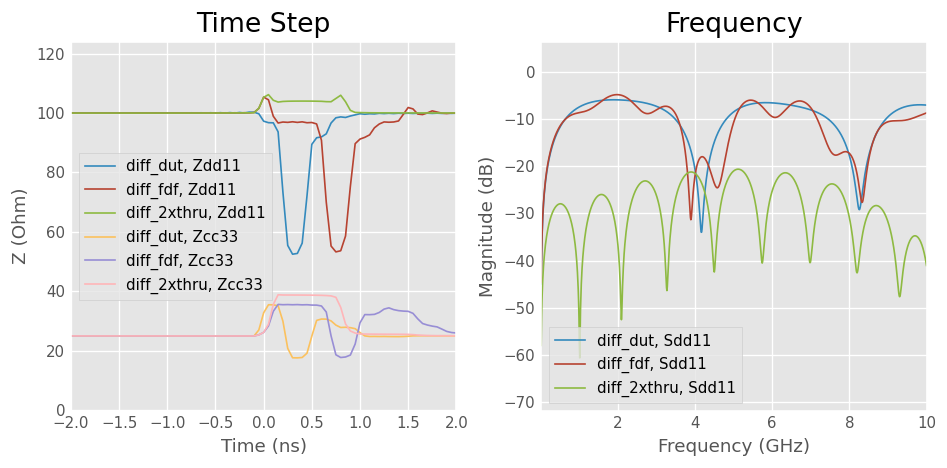

In [29]:
# load single-ended data
se_dut = rf.Network(directory + 'diff_dut.s4p')
se_2xthru = rf.Network(directory + 'diff_2xthru_with_connectors.s4p')
se_2xthru.name = 'diff_2xthru'
#se_2xthru = se_2xthru.delay(10, 'ps', 3) # skew
se_fdf = rf.Network(directory + 'diff_fdf_with_connectors.s4p')
se_fdf.name = 'diff_fdf'
#se_fdf = se_fdf.delay(10, 'ps', 0) # skew

# transform to mixed-modes
mm_dut = se_dut.copy()
mm_dut.se2gmm(p = 2)
mm_2xthru = se_2xthru.copy()
mm_2xthru.se2gmm(p = 2)
mm_fdf = se_fdf.copy()
mm_fdf.se2gmm(p = 2)

# extrapolate to DC for time step
mm_dut_dc = IEEEP370.extrapolate_to_dc(mm_dut)
mm_2xthru_dc = IEEEP370.extrapolate_to_dc(mm_2xthru)
mm_fdf_dc = IEEEP370.extrapolate_to_dc(mm_fdf)

# set True to write .s4p files
if False:
    connectors = rf.concat_ports([connector, connector], port_order = 'second')
    se_2xthru = connectors ** rf.Network(directory + 'diff_2xthru.s4p') ** connectors
    se_fdf = connectors ** rf.Network(directory + 'diff_fdf.s4p') ** connectors
    se_2xthru.write_touchstone(directory + 'diff_2xthru_with_connectors.s4p')
    se_fdf.write_touchstone(directory + 'diff_fdf_with_connectors.s4p')

# looking at the newtorks
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_title('Time Step')
mm_dut_dc.plot_z_time_step(0, 0, ax = axs[0])
mm_fdf_dc.plot_z_time_step(0, 0, ax = axs[0])
mm_2xthru_dc.plot_z_time_step(0, 0, ax = axs[0])
mm_dut_dc.plot_z_time_step(2, 2, ax = axs[0])
mm_fdf_dc.plot_z_time_step(2, 2, ax = axs[0])
mm_2xthru_dc.plot_z_time_step(2, 2, ax = axs[0])
axs[0].set_xlim((-2, 2))
axs[0].legend(loc = 'center left')

axs[1].set_title('Frequency')
mm_dut.plot_s_db(0, 0, ax = axs[1])
mm_fdf.plot_s_db(0, 0, ax = axs[1])
mm_2xthru.plot_s_db(0, 0, ax = axs[1])
axs[1].legend(loc = 'lower left')

fig.tight_layout()

First, check the quality metrics of the data to ensure they do not violate passivity, reciprocity, or causality. Initial quality checking in the frequency domain results in percentage scores and is informative only. The results are evaluated as good, acceptable, inconclusive or poor. Inconclusive or poor results may indicate the need to recalibrate the VNA and perform the measurements again.

Application-based quality checking in the time domain compares the original data to reconstructed S-parameters with enforced passivity, reciprocity, and causality. The quality estimations are in physical units such as voltage and time. `scikit-rf` does not implement application-based checking.

In [33]:
print('Frequency domain initial quality checking')

qm_2xthru = IEEEP370.check_fd_mm_quality(mm_2xthru)
print(f'{s2xthru.name}:')
print('differential mode')
for k, v in qm_2xthru['dd'].items():
    print(f'{k}: {v}')      
print('common mode')
for k, v in qm_2xthru['cc'].items():
    print(f'{k}: {v}')

qm_fdf = IEEEP370.check_fd_mm_quality(mm_fdf)
print(f'{fdf.name}:')
print('differential mode')
for k, v in qm_fdf['dd'].items():
    print(f'{k}: {v}')
print('common mode')
for k, v in qm_fdf['cc'].items():
    print(f'{k}: {v}')

Frequency domain initial quality checking
2x-Thru:
differential mode
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 48.79980270849978, 'evaluation': 'Poor'}
common mode
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 45.843237193764935, 'evaluation': 'Poor'}
FIX-DUT-FIX:
differential mode
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 51.83546762596377, 'evaluation': 'Poor'}
common mode
passivity: {'value': 100.0, 'evaluation': 'Good'}
reciprocity: {'value': 100.0, 'evaluation': 'Good'}
causality: {'value': 53.19043331530193, 'evaluation': 'Poor'}


Before exercising the deembedding algorithms, the compliance of input data with IEEE 370 fixture electrical requirements (FER) shall be verified.

In [ ]:
fig = IEEEP370.plot_check_mm_fer_s(se_2xthru)

In [ ]:
fig = IEEEP370.plot_check_mm_fer_z(se_2xthru, se_fdf)

The performance of the 2x-Thru is deemed class C compliant for frequencies below 10 GHz. This is due to the artificial impedance mismatch between 2x-Thru and FIX-DUT-FIX that fails the FER5 A and B limits.

### IEEEP370_MM_NZC_2xThru without impedance correction <a class="anchor" id="mmnzc"></a>
This method takes the 2x-Thru as input. It is a simple and efficient bisection algorithm that cannot correct for the difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX. This unwanted difference should be minimized. It can appear because of materials inhomogeneities, manufacturing processes, or if the artifacts are not built on the same board.

The S-parameters bisection is done by time gating S11 and S22, taking the proper square root of the S21 corrected by return loss, and remixing the parameters according to the fixture signal flow graph. This method gives crude results but is robust.

IEEE 370 recommends the following consistency tests:

* Self de-embedding of 2x-Thru with absolute magnitude of residual insertion loss < ±0.1 dB and residual phase < ±1°

* Compare the TDR of the fixture model to the FIX-DUT-FIX


In [ ]:
# de-embedding
z0 = 50
dm_mmnzc  = IEEEP370_MM_NZC_2xThru(dummy_2xthru = se_2xthru, z0 = z0, name = 'mmnzc')
mm_nzc_side1 = dm_mmnzc.se_side1.copy()
mm_nzc_side1.name = 'FIX-1-2'
mm_nzc_side1.se2gmm(p = 2)
se_d_dut_nzc = dm_mmnzc.deembed(se_fdf)
se_d_dut_nzc.name = 'd_dut_nzc'
mm_d_dut_nzc = se_d_dut_nzc.copy()
mm_d_dut_nzc.se2gmm(p = 2)
mm_nzc_side1_dc = IEEEP370.extrapolate_to_dc(mm_nzc_side1)
mm_d_dut_nzc_dc = IEEEP370.extrapolate_to_dc(mm_d_dut_nzc)

fig, ax = dm_mmnzc.plot_check_residuals()

The agreement between fixtures models and 2xthru is excellent, as shown by the magnitude and phase of residuals being much smaller than IEEEP370 ±0.1 dB and ±1° limits.

In [ ]:
fig, ax = dm_mmnzc.plot_check_impedance(se_fdf)

Both fixtures show a close agreement with 2x-Thru from the start to the middle. However, the artificial impedance mismatch added between 2x-Thru and FIX-DUT-FIX will deteriorate the DUT deembedding performance.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Time Step')
mm_fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
mm_d_dut_nzc_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
mm_dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
mm_fdf_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dotted', color = 'b')
mm_d_dut_nzc_dc.plot_z_time_step(2, 2, ax = axs[0], color = 'c')
mm_dut_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-2, 2))
axs[0].legend(loc = 'center left')

axs[1].set_title('Frequency')
mm_fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
mm_d_dut_nzc.plot_s_db(0, 0, ax = axs[1], color = 'r')
mm_dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

The NZC deembedding algorithm has removed the delay of the fixtures. As expected, the impedance mismatch between 2x-Thru and FIX-DUT-FIX deteriorates the de-embedding by leaving an impedance bounce before time zero in the time domain. It is also visible as a ripple in the frequency domain.

### IEEEP370_MM_ZC_2xThru with impedance correction <a class="anchor" id="mmzc"></a>
This method take 2x-Thru and FIX-DUT-FIX as inputs. It makes a correction for the (unwanted) difference of impedance between the lines of FIX-FIX and FIX-DUT-FIX.

The algorithm computes the length of the fixtures by halving the delay of 2x-Thru in time domain transmission. The propagation constant gamma is also determined from the 2xThru. It then peels the FIX-DUT-FIX time domain impedance profile iteratively in cycles of determining start impedance and deembedding a single time sample long transmission line.

IEEEP370_MM_ZC_2xThru has more options and often give better results than IEEEP370_MM_NZC_2xThru, but it consumes more processing power.

In [ ]:
# de-embedding
dm_mmzc  = IEEEP370_MM_ZC_2xThru(dummy_2xthru = se_2xthru, dummy_fix_dut_fix = se_fdf,
                         bandwidth_limit = 10e9, pullback1 = 0, pullback2 = 0,
                         leadin = 0, NRP_enable = False, name = 'mmzc')
mm_zc_side1 = dm_mmzc.se_side1.copy()
mm_zc_side1.name = 'FIX-1-2'
mm_zc_side1.se2gmm(p = 2)
se_d_dut_zc = dm_mmzc.deembed(se_fdf)
se_d_dut_zc.name = 'd_dut_zc'
mm_d_dut_zc = se_d_dut_zc.copy()
mm_d_dut_zc.se2gmm(p = 2)
mm_zc_side1_dc = IEEEP370.extrapolate_to_dc(mm_zc_side1)
mm_d_dut_zc_dc = IEEEP370.extrapolate_to_dc(mm_d_dut_zc)

fig, ax = dm_mmzc.plot_check_residuals()

The agreement between fixtures models and 2xthru is good, as shown by the magnitude and phase of residuals differential mode being smaller than IEEE 370 ±0.1 dB and ±1° limits. The common mode residuals are within ±0.3 dB and ±6° which is higher but not catastrophic.

The residuals are higher than than with the NZC algorithm. This is the awaited result because the fixtures are modeled on the FIX-DUT-FIX impedance profile that has an artificially added impedance mismatch with the 2x-Thru. This is especially true for common mode.

In [ ]:
fig, ax = dm_mmzc.plot_check_impedance()

Both fixtures show a close agreement with FIX-DUT-FIX from the start to the middle. The 2x-Thru was used for fixture length and propagation constant gamma determination only.

The `leadin` option is useful if there is a need to capture several non-reference impedance samples before the time zero. The `pullback1` and `pullback2` options can shorten the fixtures by an integer number of time samples.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Time Step')
mm_fdf_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dotted', color = 'm')
mm_d_dut_zc_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
mm_dut_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
mm_fdf_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dotted', color = 'b')
mm_d_dut_zc_dc.plot_z_time_step(2, 2, ax = axs[0], color = 'c')
mm_dut_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].set_xlim((-2, 2))
axs[0].legend(loc = 'center left')

axs[1].set_title('Frequency')
mm_fdf.plot_s_db(0, 0, ax = axs[1], color = 'm', linestyle = 'dotted')
mm_d_dut_zc.plot_s_db(0, 0, ax = axs[1], color = 'r')
mm_dut.plot_s_db(0, 0, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].set_ylim((-40, 5))
fig.tight_layout()

As expected, the ZC deembedding algorithm shows a better agreement with the reference DUT than NZC, both in the time and frequency domains. This is because it is not impacted by the impedance mismatch between 2xThru and FIX-DUT-FIX of this example. This impedance difference should be minimized as much as possible in practical designs.

### Mixed Mode Comparison with AICC De-Embedding Utility <a class="anchor" id="mmaicc"></a>
Let's compare the deembedded DUTs from `scikit-rf` and `AICC De-Embedding Utility` to conclude this notebook.

In [ ]:
# load single-ended data
se_ref_nzc = rf.Network(directory + 'deembedded_MM_NZC_diff_fdf_with_connectors.s4p')
se_ref_nzc.name = 'aicc_nzc'
se_ref_zc = rf.Network(directory + 'deembedded_MM_ZC_diff_fdf_with_connectors.s4p')
se_ref_zc.name = 'aicc_zc'

# transform to mixed-modes
mm_ref_nzc = se_ref_nzc.copy()
mm_ref_nzc.se2gmm(p = 2)
mm_ref_zc = se_ref_zc.copy()
mm_ref_zc.se2gmm(p = 2)

# extrapolate to DC for time step
mm_ref_nzc_dc = IEEEP370.extrapolate_to_dc(mm_ref_nzc)
mm_ref_zc_dc = IEEEP370.extrapolate_to_dc(mm_ref_zc)

# make purposely wrong NZC side 2 flip for comparison with AICC Tool
se_nzc_wrong_d_dut = dm_mmnzc.se_side1.inv ** se_fdf ** dm_mmnzc.se_side2.inv
mm_nzc_wrong_d_dut = se_nzc_wrong_d_dut.copy()
mm_nzc_wrong_d_dut.se2gmm(p=2)
mm_nzc_wrong_d_dut.name = 'wrong flip'
mm_nzc_wrong_d_dut_dc = IEEEP370.extrapolate_to_dc(mm_nzc_wrong_d_dut)

# compute absolute differences
# division of complex reflexion coeff is like substraction in dB and deg
delta_nzc = mm_ref_nzc / mm_nzc_wrong_d_dut
delta_zc = mm_ref_zc / mm_d_dut_zc

# plot them all
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_title('AICC Tool NZC side 1')
mm_nzc_wrong_d_dut_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
mm_d_dut_nzc_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'g')
mm_ref_nzc_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
mm_nzc_wrong_d_dut_dc.plot_z_time_step(2, 2, ax = axs[0], color = 'b')
mm_d_dut_nzc_dc.plot_z_time_step(2, 2, ax = axs[0], color = 'c')
mm_ref_nzc_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].legend(loc = 'center right')
axs[0].set_xlim((-1, 2))

axs[1].set_title('AICC Tool NZC side 2')
mm_nzc_wrong_d_dut_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'r')
mm_d_dut_nzc_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'g')
mm_ref_nzc_dc.plot_z_time_step(1, 1, ax = axs[1], linestyle = 'dashed', color = 'k')
mm_nzc_wrong_d_dut_dc.plot_z_time_step(3, 3, ax = axs[1], color = 'b')
mm_d_dut_nzc_dc.plot_z_time_step(3, 3, ax = axs[1], color = 'c')
mm_ref_nzc_dc.plot_z_time_step(3, 3, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].legend(loc = 'center right')
axs[1].set_xlim((-1, 2))

fig.tight_layout()

When comparing `scikit-rf` and `AICC` results, NZC algorithm exhibits a small discrepancy after the DUT section (green curve). This is because `AICC` FIX-2 has a wrong flip, which is demonstrated by the results of side 1 and side 2 being different for a symmetrical FIX-DUT-FIX (dashed black curve). If this error is propagated to `scikit-rf` for comparison's sake, the agreement is a perfect fit (red curve). The version of `AICC` used is 1.0.0.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('AICC Tool NZC side 1')

axs[0].set_title('AICC Tool ZC side 1')
mm_d_dut_zc_dc.plot_z_time_step(0, 0, ax = axs[0], color = 'r')
mm_ref_zc_dc.plot_z_time_step(0, 0, ax = axs[0], linestyle = 'dashed', color = 'k')
mm_d_dut_zc_dc.plot_z_time_step(2, 2, ax = axs[0], color = 'c')
mm_ref_zc_dc.plot_z_time_step(2, 2, ax = axs[0], linestyle = 'dashed', color = 'k')
axs[0].legend(loc = 'center right')
axs[0].set_xlim((-1, 2))

axs[1].set_title('AICC Tool NZC side 2')
mm_d_dut_zc_dc.plot_z_time_step(1, 1, ax = axs[1], color = 'r')
mm_ref_zc_dc.plot_z_time_step(1, 1, ax = axs[1], linestyle = 'dashed', color = 'k')
mm_d_dut_zc_dc.plot_z_time_step(3, 3, ax = axs[1], color = 'c')
mm_ref_zc_dc.plot_z_time_step(3, 3, ax = axs[1], linestyle = 'dashed', color = 'k')
axs[1].legend(loc = 'center right')
axs[1].set_xlim((-1, 2))

fig.tight_layout()

When comparing `scikit-rf` and `AICC` results, ZC is visually a perfect fit in the time domain for both sides.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title('Absolute magnitude difference')
delta_nzc.plot_s_db(1, 0, ax = axs[0])
delta_nzc.plot_s_db(3, 2, ax = axs[0])
delta_zc.plot_s_db(1, 0, ax = axs[0])
delta_zc.plot_s_db(3, 2, ax = axs[0])
axs[0].legend(loc = 'upper right')

axs[1].set_title('Absolute phase difference')
delta_nzc.plot_s_deg(1, 0, ax = axs[1])
delta_nzc.plot_s_deg(3, 2, ax = axs[1])
delta_zc.plot_s_deg(1, 0, ax = axs[1])
delta_zc.plot_s_deg(3, 2, ax = axs[1])
axs[1].legend(loc = 'upper right')

fig.tight_layout()

The agreement between `scikit-rf` and `AICC De-Embedding Utility` is better than ±0.05 dB and ±0.5° for the NZC algorithm. For ZC it keep within ±0.4 dB and ±2° on full bandwidth, that is good enought.

In conclusion, for the specific mixed mode case studied, we can say that `scikit-rf` gives consistent results with `AICC De-embedding Utility` implementation in IEEEP370 deembedding routines. It also solves the NZC FIX-2 flip error in `AICC De-embedding Utility` version 1.0.0.